## Generate synthetic data

In [ ]:
import dotenv

dotenv.load_dotenv(dotenv.find_dotenv())

from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import AzureChatOpenAI
from langchain_core.messages import HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from pathlib import Path
from tqdm import tqdm
from typing import Dict, Optional, List
import random

In [ ]:
llm = AzureChatOpenAI(
    temperature=0.0,
    azure_deployment="gpt4o",
    openai_api_version="2023-07-01-preview",
)

In [ ]:
class TrashItem(BaseModel):
    """
    A trash item that needs to be sorted into a category.
    """

    item_id: Optional[str] = Field(description="The unique identifier of the item.")
    direction: Optional[str] = Field(
        description="How to dispose of the item according to the rules."
    )


class Quirk(BaseModel):
    """
    A local rule or quirk relevant to the person trying to sort their garbage.
    Should include a concrete fine, specific sorting rule, collection day of the week, etc.
    Should not include general information like "fines may apply" or "state plans to enforce this law by 2025".
    Should not include rules that apply to facilities or businesses, only to individuals.
    """

    description: Optional[str] = Field(
        description="A description of the rule or quirk."
    )


class SortingInfo(BaseModel):
    """
    Information about how to sort a list of trash items.
    """

    sorted_items: Optional[List[TrashItem]] = Field(
        description="A list of trash items and their corresponding categories."
    )
    local_quirks: Optional[List[Quirk]] = Field(
        description="Local quirks that need to be taken into account when sorting the items."
    )

In [ ]:
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert extraction algorithm designed to help with sorting garbage items based on local waste disposal rules. "
            "You will receive a list of garbage item names and need to assign each one to its corresponding category according to the provided disposal rules. "
            "Only extract relevant information from the text. "
            "If you do not know the value of an attribute asked to extract, return null for the attribute's value.",
        ),
        # ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
        MessagesPlaceholder("examples"),  # <-- EXAMPLES!
        # ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
        ("human", "{rules}\n===\n{items}"),
    ]
)

# prompt.invoke(
#     {
#         "rules": "some rules",
#         "items": "this is items",
#         "examples": [HumanMessage(content="testing 1 2 3")],
#     }
# )

In [ ]:
import uuid
from typing import Dict, List, TypedDict

from langchain_core.messages import (
    AIMessage,
    BaseMessage,
    HumanMessage,
    SystemMessage,
    ToolMessage,
)
from langchain_core.pydantic_v1 import BaseModel, Field


class Example(TypedDict):
    """A representation of an example consisting of text input and expected tool calls.

    For extraction, the tool calls are represented as instances of pydantic model.
    """

    input: str  # This is the example text
    tool_calls: List[BaseModel]  # Instances of pydantic model that should be extracted


def tool_example_to_messages(example: Example) -> List[BaseMessage]:
    """Convert an example into a list of messages that can be fed into an LLM.

    This code is an adapter that converts our example to a list of messages
    that can be fed into a chat model.

    The list of messages per example corresponds to:

    1) HumanMessage: contains the content from which content should be extracted.
    2) AIMessage: contains the extracted information from the model
    3) ToolMessage: contains confirmation to the model that the model requested a tool correctly.

    The ToolMessage is required because some of the chat models are hyper-optimized for agents
    rather than for an extraction use case.
    """
    messages: List[BaseMessage] = [HumanMessage(content=example["input"])]
    tool_calls = []
    for tool_call in example["tool_calls"]:
        tool_calls.append(
            {
                "id": str(uuid.uuid4()),
                "args": tool_call.dict(),
                # The name of the function right now corresponds
                # to the name of the pydantic model
                # This is implicit in the API right now,
                # and will be improved over time.
                "name": tool_call.__class__.__name__,
            },
        )
    messages.append(AIMessage(content="", tool_calls=tool_calls))
    tool_outputs = example.get("tool_outputs") or [
        "You have correctly called this tool."
    ] * len(tool_calls)
    for output, tool_call in zip(tool_outputs, tool_calls):
        messages.append(ToolMessage(content=output, tool_call_id=tool_call["id"]))
    return messages

In [ ]:
with open("korea_summary.txt", "r") as f:
    example_rules = f.read()

example_items = [
    {"item_id": 0, "class": "plastic"},
    {"item_id": 1, "class": "paper"},
    {"item_id": 2, "class": "foam"},
    {"item_id": 3, "class": "food"},
]
example_input = f"{example_rules}\n===\n{example_items}"


example_output = SortingInfo(
    sorted_items=[
        TrashItem(item_id="0", direction="Recyclable Waste (재활용 쓰레기) (No special bags required)"),
        TrashItem(item_id="1", direction="Recyclable Waste (재활용 쓰레기) (No special bags required)"),
        TrashItem(item_id="2", direction="General Waste Bag (일반 쓰레기 봉투)"),
        TrashItem(item_id="3", direction="Food Waste Bag (음식물 쓰레기 봉투)"),
    ],
    local_quirks=[
        Quirk(
            description="Make sure to put items in appropriate garbage bags. Garbage bags are color-coded and district-specific. You can get them at local convenience stores."
        ),
        Quirk(description="Penalty for non-compliance is a fine of up to 300,000 KRW."),
        Quirk(description="Do not put egg shells, seafood shells, and animal bones into the Food Waste Bag."),
    ],
)

examples = [
    (
        example_input,
        example_output,
    )
]

messages = []

for text, tool_call in examples:
    messages.extend(
        tool_example_to_messages({"input": text, "tool_calls": [tool_call]})
    )

# example_prompt = prompt.invoke(
#     {"rules": "some rules", "items": "this is items", "examples": messages}
# )

# for message in example_prompt.messages:
#     print(f"{message.type}: {message}")

In [ ]:
runnable = prompt | llm.with_structured_output(schema=SortingInfo)

In [ ]:
rule_files = [
    "korea_summary.txt",
    "california_summary.txt",
]

local_rules = []
for file in rule_files:
    with open(file) as f:
        local_rules.append(f.read())


def get_random_rules():
    return local_rules[random.randint(0, len(local_rules) - 1)]

In [ ]:
from datasets import Dataset

ds = Dataset.load_from_disk("taco_trash")

In [ ]:
# ds[0]

In [ ]:
# import supervision as sv
import numpy as np
import cv2
from tqdm import tqdm
from collections import defaultdict
import PIL
import json
import itertools


NUM_SAMPLES = 1000

COLORS = [
    (0, 255, 255),  # Cyan
    (255, 128, 128),  # Salmon
    (255, 0, 255),  # Magenta
    (255, 128, 0),  # Orange
    (128, 255, 0),  # Lime
    (0, 255, 128),  # Spring Green
    (255, 0, 128),  # Rose
    (128, 0, 255),  # Violet
    (0, 128, 255),  # Azure
    (128, 255, 128),  # Chartreuse
    (128, 128, 255),  # Cornflower Blue
    (255, 255, 128),  # Light Yellow
    (255, 128, 255),  # Orchid
    (128, 255, 255),  # Light Cyan
    (255, 165, 0),  # Also orange
    (0, 255, 255),  # Aqua
    (255, 0, 255),  # Fuchsia
    (128, 0, 0),  # Maroon
    (128, 128, 0),  # Olive
    (0, 128, 128),  # Teal
    (128, 0, 128),  # Purple
]

colors = itertools.cycle(COLORS)


def draw_contours(image, masks):
    for j, mask in enumerate(masks):
        mask = np.array(mask)

        contours, _ = cv2.findContours(
            mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        image = cv2.drawContours(image, contours, -1, next(colors), 3)

        if not contours:
            continue

        # Calculate the center of the outline
        M = cv2.moments(contours[0])

        if M["m00"] == 0:
            continue

        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])

        # Add a backdrop to the label for visibility
        # text_size, _ = cv2.getTextSize(str(0), cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
        cv2.rectangle(
            image,
            (cX - 5, cY - 30),
            (cX + 30, cY + 5),
            (0, 0, 0),  # Black color for the backdrop
            -1,  # Fill the rectangle
        )

        # Draw the label with the index of the mask in the middle of the outline
        cv2.putText(
            image,
            str(j),  # Replace 0 with the index of the mask
            (cX, cY),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (255, 255, 255),  # White color for the text
            2,
            cv2.LINE_AA,
        )
    return image


def generate_annotations(seg_classes, original_classes):
    items = [
        {"item_id": i, "class": seg_class} for i, seg_class in enumerate(seg_classes)
    ]
    rules = get_random_rules()

    sorting_info: SortingInfo = runnable.invoke(
        {"rules": rules, "items": items, "examples": messages}
    )

    suffix_dict = {
        "sorted_items": [],
        "local_quirks": [quirk.dict() for quirk in sorting_info.local_quirks],
    }

    for item in sorting_info.sorted_items:
        new_item = {
            "item_id": item.item_id,
            "refined_label": original_classes[int(item.item_id)],
            "direction": item.direction,
        }
        suffix_dict["sorted_items"].append(new_item)

    prefix = {
        "rules": rules,
        "items": items,
    }

    return {
        "prefix": prefix,
        "suffix": suffix_dict,
    }


tmp_path = Path("tmp_gpt_outputs.json")
tmp_path.touch(exist_ok=True)
annotations_map = {}

with tmp_path.open("r") as f:
    for line in f.readlines():
        tmp_dict = json.loads(line)
        annotations_map[tmp_dict["sample_index"]] = tmp_dict["annotations"]

dataset_dict = defaultdict(list)

for i, sample in tqdm(enumerate(ds)):
    if i >= NUM_SAMPLES:
        break

    image = np.array(sample["image"])
    image = draw_contours(image, sample["masks"])

    if i in annotations_map:
        annotations = annotations_map[i]
    else:
        annotations = generate_annotations(
            sample["classes"], sample["original_classes"]
        )
        with tmp_path.open("a") as f:
            f.write(json.dumps({"sample_index": i, "annotations": annotations}) + "\n")

    # print(annotations["suffix"])

    dataset_dict["image"].append(PIL.Image.fromarray(image))
    dataset_dict["prefix"].append(annotations["prefix"])
    dataset_dict["suffix"].append(annotations["suffix"])

dataset = Dataset.from_dict(dataset_dict)
dataset.save_to_disk("taco_trash_json_1K")

In [ ]:
dataset[0]

In [ ]:
import PIL

PIL.Image.fromarray(image)

## Train the model

In [ ]:
from training_toolkit import build_trainer, paligemma_image_preset

In [ ]:
from training_toolkit import DataPreset
from training_toolkit.common.tokenization_utils.json import JSONTokenizer
from string import Template

# Define the template string
PREFIX_TEMPLATE = Template("For every object outlined in the image, here're their detected classes: $items. "
                           "For every outlined item, extract JSON with a more accurate label, "
                           "as well as disposal directions based on local rules. "
                           "The local rules are as follows: $rules.")


class TrashJSONCollator:

    def __init__(self, processor):
        self.processor = processor
        self.json_tokenizer = JSONTokenizer(processor)

    def __call__(self, examples):
        json_dicts = [example["suffix"] for example in examples]
        labels = [self.json_tokenizer.encode(json_dict) for json_dict in json_dicts]

        images = [example["image"] for example in examples]

        rules = [example["prefix"]["rules"] for example in examples]
        items = [example["prefix"]["items"] for example in examples]
        texts = [PREFIX_TEMPLATE.substitute(items=item, rules=rule)  for item, rule in zip(items, rules)]

        tokens = self.processor(
            text=texts,
            images=images,
            suffix=labels,
            return_tensors="pt",
            padding="longest",
        )

        return tokens



trash_json_preset = DataPreset(
    train_test_split=0.2,
    collator_cls=TrashJSONCollator,
)

In [ ]:
# from transformers import AutoProcessor

# processor = AutoProcessor.from_pretrained("google/paligemma-3b-mix-224")

# prepared_datasets = trash_json_preset.with_path("taco_trash_json").as_kwargs()
# train_dataset = prepared_datasets["train_dataset"]

# collator = prepared_datasets["collator_cls"](processor)

# collator([train_dataset[0]])

In [ ]:
paligemma_image_preset.training_args["per_device_train_batch_size"] = 8
paligemma_image_preset.training_args["per_device_eval_batch_size"] = 8
paligemma_image_preset.training_args["eval_strategy"] = "no"
paligemma_image_preset.training_args["num_train_epochs"] = 10

trainer = build_trainer( 
    **paligemma_image_preset.as_kwargs(),
    **trash_json_preset.with_path("taco_trash_json_1K").as_kwargs(apply_train_test_split=False),
)

In [ ]:
trainer.train()

In [ ]:
len(trainer.train_dataset)

In [ ]:
trainer.train_dataset[0]["suffix"]

In [ ]:
trainer.save_model("taco_trash_json_model")

In [ ]:
collator = trainer.data_collator
collator

In [ ]:
collator([trainer.train_dataset[0]]).keys()

In [ ]:
input_ids = collator([trainer.train_dataset[500]])["input_ids"]

In [ ]:
from transformers import AutoProcessor


CHECKPOINT_PATH = "paligemma_2024-08-13_07-21-14/checkpoint-240"
processor = AutoProcessor.from_pretrained(CHECKPOINT_PATH)

generated_text = processor.batch_decode(
    input_ids,
    skip_special_tokens=False,
)[0]

In [ ]:
print(generated_text)

In [ ]:
!nvidia-smi

## Run inference

In [1]:
from peft import AutoPeftModelForCausalLM
from transformers import AutoProcessor
from datasets import load_from_disk

from training_toolkit.common.tokenization_utils.json import (
    JSONTokenizer,
)

/home/azureuser/.conda/envs/trash_demo/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
CHECKPOINT_PATH = "paligemma_2024-08-13_07-21-14/checkpoint-240"

model = AutoPeftModelForCausalLM.from_pretrained(CHECKPOINT_PATH)
processor = AutoProcessor.from_pretrained(CHECKPOINT_PATH)
json_tokenizer = JSONTokenizer(processor)

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.
Loading checkpoint shards: 100%|██████████| 3/3 [00:01<00:00,  2.22it/s]


In [3]:
from string import Template


dataset = load_from_disk("taco_trash_json")
image = dataset[0]["image"]
image

rules = dataset[0]["prefix"]["rules"]
items = dataset[0]["prefix"]["items"]

PREFIX_TEMPLATE = Template("For every object outlined in the image, here're their detected classes: $items. "
                           "For every outlined item, extract JSON with a more accurate label, "
                           "as well as disposal directions based on local rules. "
                           "The local rules are as follows: $rules.")

prompt = PREFIX_TEMPLATE.substitute(items=items, rules=rules)

In [4]:
prompt

"For every object outlined in the image, here're their detected classes: [{'class': 'glass', 'item_id': 0}]. For every outlined item, extract JSON with a more accurate label, as well as disposal directions based on local rules. The local rules are as follows: ### Organic Waste Collection Rules for Residents and Businesses\n\n---\n\n### Collection Service Options\n\n1. **Source-Separated Organic Waste Collection**\n   - Separate waste into three, two, or more containers.\n\n2. **Single Container Waste Collection**\n   - Organic waste is collected with garbage and recyclables and separated later at a processing facility.\n\n**Uncontainerized green waste and yard waste** can be collected in the streets if requirements are met. The use of plastic or compostable bags in green containers is at the jurisdiction's discretion.\n\n---\n\n### Three-Container Collection Service\n\nResidents and businesses separate waste into:\n- **Green Container**: Food waste, yard waste, green waste, and other o

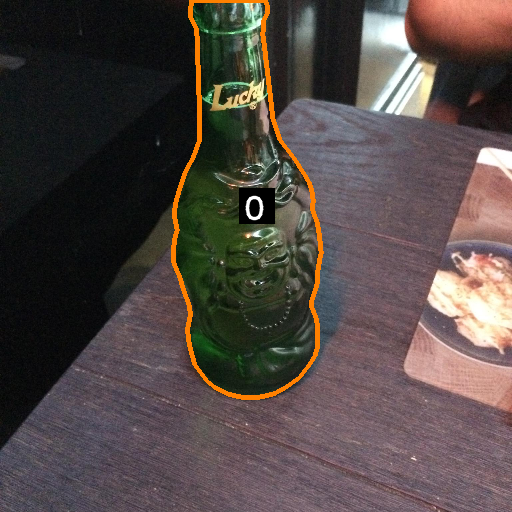

In [5]:
image

In [6]:
inputs = processor(images=image, text=prompt, return_tensors="pt")
generated_ids = model.generate(**inputs, max_new_tokens=1024, do_sample=True)

# Next we turn each predicted token ID back into a string using the decode method
# We chop of the prompt, which consists of image tokens and our text prompt

generated_text = processor.batch_decode(
    generated_ids,
    skip_special_tokens=True,
)[0]

generated_json = json_tokenizer.decode(generated_text)

In [7]:
print(generated_text)
# print(json_tokenizer.decode(generated_text[:-17]))

For every object outlined in the image, here're their detected classes: [{'class': 'glass', 'item_id': 0}]. For every outlined item, extract JSON with a more accurate label, as well as disposal directions based on local rules. The local rules are as follows: ### Organic Waste Collection Rules for Residents and Businesses

---

### Collection Service Options

1. **Source-Separated Organic Waste Collection**
   - Separate waste into three, two, or more containers.

2. **Single Container Waste Collection**
   - Organic waste is collected with garbage and recyclables and separated later at a processing facility.

**Uncontainerized green waste and yard waste** can be collected in the streets if requirements are met. The use of plastic or compostable bags in green containers is at the jurisdiction's discretion.

---

### Three-Container Collection Service

Residents and businesses separate waste into:
- **Green Container**: Food waste, yard waste, green waste, and other organic materials.
- 

In [8]:
print(generated_json)

{'sorted_items': [{'refined_label': 'Glass bottle', 'item_id': '0', 'direction': 'Blue Container (Traditional recyclables and organic waste)'}, {'refined_label': 'Glass bottle', 'item_id': '0', 'direction': 'Blue Container (Traditional recyclables and organic waste)'}], 'local_quirks': [{'description': 'Non-compliance with sorting and disposal regulations may result in fines.'}, {'description': 'Residents and businesses must separate waste into appropriate containers based on the collection service option chosen.'}]}
